In [7]:
import zipfile
from io import BytesIO
import  urllib

# only for first download of dataset

url = "https://zenodo.org/record/1290750/files/IRMAS-TrainingData.zip?download=1"

response = urllib.request.urlopen(url)
data = response.read()
file = zipfile.ZipFile(BytesIO(data))
file.extractall(path="./data/") # extract zip to folder


In [1]:
import os
import librosa
import numpy as np

data_dir = os.path.join(os.getcwd(), "data/IRMAS-TrainingData/")
clsnames = ['gel', 'pia', 'voi', 'cel']
sr = 44100
signals = []
labels = []

for label, clsname in enumerate(clsnames):
    clsdir = os.path.join(data_dir, clsname)
    for file in os.listdir(clsdir):
        if file.endswith('.wav'):
            filepath = os.path.join(clsdir, file)
            y, _ = librosa.load(filepath, sr=sr, mono=True)    
            signals.append(y)
            labels.append(label)

signals = np.array(signals)
labels = np.array(labels)

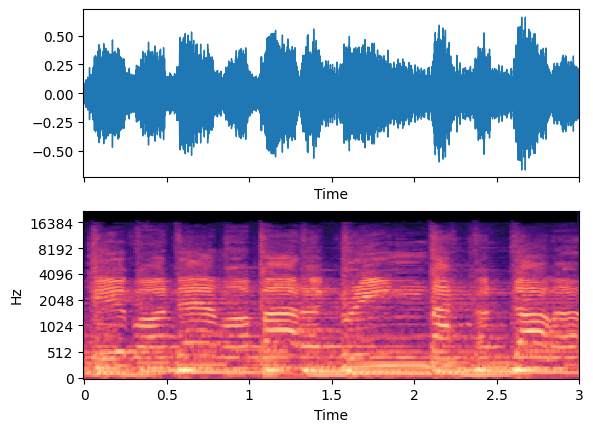

In [3]:
from matplotlib import pyplot as plt


i = 2010
y = signals[i]
label = clsnames[labels[i]]

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)

librosa.display.waveshow(y, sr=sr, ax=axs[0])

S_mel = librosa.feature.melspectrogram(y=y, sr=sr, window='hann', hop_length=512, n_fft=2048)
S_mel_db = librosa.power_to_db(S_mel)
librosa.display.specshow(S_mel_db, sr=sr, x_axis="time", y_axis="mel", ax=axs[1], cmap="magma")

In [4]:

from sklearn.model_selection import train_test_split

spectrograms = np.array([librosa.feature.melspectrogram(y=signal, sr=sr) for signal in signals])
spectrograms_db = librosa.power_to_db(spectrograms)

features = np.reshape(spectrograms_db, (spectrograms_db.shape[0], -1)) # flatten

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42) # set random state so the test set is always the same
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([    
    ('normalize', StandardScaler()),    
    ('classifier', RandomForestClassifier(250))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('normalize', StandardScaler()),
                ('classifier', RandomForestClassifier(n_estimators=250))])

In [6]:
x_hat_test = pipe.predict(X_test)

def error(x_hat, y):
    return np.mean(x_hat != y)

error(x_hat_test, y_test)

0.3471698113207547